# COVID-19 Cough Detection


### Task Description：
In this notebook, we further tune and train a HuBERT model to detect the presence of COVID-19 in audio cough samples.


### Solution:
This program will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training 
5. Testing 

### Install dependencies

In [ ]:
! pip install transformers
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. General Preparation

Import some necessary libraries.

In [ ]:
import time
from tqdm import tqdm
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, roc_curve

from torch.utils.data import DataLoader

Use GPU Facilities.

In [ ]:
cuda_id = 0
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda:0 - Tesla T4


In [ ]:
torch.cuda.device_count() 

1

## 2. Data Processing

The data is taken from Virufy S3 buckets, which have been pushed to a Drive folder for easier integration. To read the data, we mount the notebook directory to said folder.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

As seen in our data exploration, the data is highly skewed. To combat this, we take some measures to combat class imbalance by maintaining a ratio of negative to positive samples as 3:1. While a 1:1 ratio would be ideal, the lack of positive samples in the data would result in far too few data points to train our model, leading to its inability to generalize well. 

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/capstone_data/data/model_train_data_set_1_public.csv')
train_data = train_data.reset_index(drop=True)
train_data = train_data[['source','audio_path','pcr_test_result_inferred']]
train_data = train_data.loc[train_data.audio_path.str.startswith('virufy-cdf-iatos')==False]
positive = train_data[train_data['pcr_test_result_inferred']==1]
negative = train_data[train_data['pcr_test_result_inferred']==0].sample(n=positive.shape[0]*3)
train_data = pd.concat([positive,negative])
train_data

,source,audio_path,pcr_test_result_inferred
16,coughvid,virufy-cdf-coughvid/00e0a33c-6561-406e-b543-4c...,1
27,coughvid,virufy-cdf-coughvid/015576c8-2b03-4dcb-b251-78...,1
57,coughvid,virufy-cdf-coughvid/031fd54a-87b5-4223-9af6-60...,1
62,coughvid,virufy-cdf-coughvid/0379c586-c500-483c-83a6-95...,1
68,coughvid,virufy-cdf-coughvid/03c1afa7-eee5-4c18-bd40-c4...,1
...,...,...,...
6912,coswara,virufy-cdf-coswara/20200416/cFePAw64vTSRzgy3ZX...,0
1121,coughvid,virufy-cdf-coughvid/327d1874-7196-4795-80d2-85...,0
6020,coswara,virufy-cdf-coswara/20200820/k0uQAYNhiUZvHePzPo...,0
3554,coughvid,virufy-cdf-coughvid/9ab8da0b-bff5-481e-b437-fd...,0


In [ ]:
val_data = pd.read_csv('/content/drive/My Drive/capstone_data/data/model_val_data_set_1_public.csv')
val_data = val_data.reset_index(drop=True)
val_data = val_data[['source','audio_path','pcr_test_result_inferred']]
val_data = val_data.loc[val_data.audio_path.str.contains('iatos')==False]
positive = val_data[val_data['pcr_test_result_inferred']==1]
negative = val_data[val_data['pcr_test_result_inferred']==0].sample(n=positive.shape[0]*3)
val_data = pd.concat([positive,negative])
val_data

,source,audio_path,pcr_test_result_inferred
47,coughvid,virufy-cdf-coughvid/06b58ff7-42e9-49d8-8b56-dd...,1
62,coughvid,virufy-cdf-coughvid/099f9c59-3206-438d-8fd5-be...,1
113,coughvid,virufy-cdf-coughvid/12121877-e33a-4cba-b63b-00...,1
117,coughvid,virufy-cdf-coughvid/126b940c-b6c6-4d3d-adc2-92...,1
141,coughvid,virufy-cdf-coughvid/178f39e2-a261-4ec6-a8fb-3f...,1
...,...,...,...
114,coughvid,virufy-cdf-coughvid/121305f0-7c36-44ad-a7ae-50...,0
1764,coswara,virufy-cdf-coswara/20200416/z3HiQpxpksYG6UTo9u...,0
1006,coughvid,virufy-cdf-coughvid/b379a0b3-05c1-492e-9f64-03...,0
19,coughvid,virufy-cdf-coughvid/02f0be6b-a241-4003-8523-52...,0


In [ ]:
train_data['pcr_test_result_inferred'].value_counts()

0    2262
1     754
Name: pcr_test_result_inferred, dtype: int64

In [ ]:
val_data['pcr_test_result_inferred'].value_counts()

0    516
1    172
Name: pcr_test_result_inferred, dtype: int64

A typical audio sample from the data is as follows.

In [ ]:
# Display the first data.

import IPython.display as ipd
id = 0
print(train_data.iloc[id])
data_var = '/content/drive/My Drive/capstone_data/data/' + train_data.iloc[id]["audio_path"]
ipd.Audio(data=data_var, autoplay=True, rate=44100)
# Sample rate = 16000

source                                                               coughvid
audio_path                  virufy-cdf-coughvid/00e0a33c-6561-406e-b543-4c...
pcr_test_result_inferred                                                    1
Name: 16, dtype: object


### 2.2 Tokenization

Perform feature extraction from these audio samples using Wav2Vec2. Wav2Vec2 is a speech model that accepts a float array corresponding to the raw waveform of the speech signal.

In [ ]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(df):
    cough, _ = librosa.load('/content/drive/My Drive/capstone_data/data/' + df["audio_path"], 
                            sr=16000, mono=True)
    df["cough"] = cough
    return df

train_data_dataset = Dataset.from_pandas(train_data).map(map_to_array)
val_data_dataset = Dataset.from_pandas(val_data).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data_dataset["cough"]), sampling_rate=16000, padding=True, return_tensors="pt")
val_encodings = feature_extractor(list(val_data_dataset["cough"]), sampling_rate=16000, padding=True, return_tensors="pt")
# Value Error for using any other sampling rate

Map:   0%|          | 0/3016 [00:00<?, ? examples/s]

Map:   0%|          | 0/688 [00:00<?, ? examples/s]

We have now encoded our training and validation data in a suitable format for HuBERT.

### 2.3 Turn data into a Dataset object

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. The PyTorch Dataset module stores the samples and their corresponding labels to enable easier access to data.

In [ ]:
class CoughDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

train_dataset = CoughDataset(train_encodings, list(train_data["pcr_test_result_inferred"]))
val_dataset = CoughDataset(val_encodings, list(val_data["pcr_test_result_inferred"]))

## 3. Loading the Model and Optimizer 

In [ ]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

## 4. Training

Prepare some utility functions.

In [ ]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Training + Val

# Set the number of epoch
epoch = 17

train_loss = list()
val_loss = list()
train_accuracies = list()
val_accuracies = list()

for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)
    # Start training
    model.train()

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    # Get test data by DataLoader
    test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    print('Train:')
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())    
    pbar.close()
    
    # record the loss and accuracy for each epoch
    # train_loss += epoch_loss
    train_loss.append(sum(epoch_loss))
    train_accuracies.append(accuracy)
    model.save_pretrained('/content/drive/My Drive/capstone_nobel/model/')

    # Start validation
    model.eval()

    with torch.no_grad():
    
        correct = 0
        count = 0
        epoch_loss = list()
        record = {"labels":list(), "predictions":list()}
        
        print('Validate:') 
        pbar = tqdm(test_loader)
        for batch in pbar:
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            
            # make predictions
            predictions = predict(outputs)

            # count accuracy
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct * 1.0 / count


            # show progress along with metrics
            pbar.set_postfix({
                'loss': '{:.3f}'.format(loss.item()),
                'accuracy': '{:.3f}'.format(accuracy)
            })
        
            # record the results
            record["labels"] += labels.cpu().numpy().tolist()
            record["predictions"] += predictions.cpu().numpy().tolist()

            # record the loss for each batch
            epoch_loss.append(loss.item())      
    pbar.close()

    # record the loss and accuracy for each epoch
    # val_loss += epoch_loss
    val_loss.append(sum(epoch_loss))
    val_accuracies.append(accuracy)
    print('')

Epoch 1/17
Train:


100%|██████████| 1508/1508 [08:55<00:00,  2.81it/s, Loss=0.097, Accuracy=0.674]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.06it/s, loss=0.017, accuracy=0.749]



Epoch 2/17
Train:


100%|██████████| 1508/1508 [08:48<00:00,  2.85it/s, Loss=0.071, Accuracy=0.718]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.08it/s, loss=0.017, accuracy=0.750]



Epoch 3/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=0.278, Accuracy=0.729]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.08it/s, loss=0.077, accuracy=0.753]



Epoch 4/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=0.185, Accuracy=0.723]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.07it/s, loss=0.094, accuracy=0.765]



Epoch 5/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=1.109, Accuracy=0.736]


Validate:


100%|██████████| 688/688 [01:16<00:00,  9.05it/s, loss=0.087, accuracy=0.763]



Epoch 6/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=0.251, Accuracy=0.750]


Validate:


100%|██████████| 688/688 [01:16<00:00,  9.05it/s, loss=0.146, accuracy=0.779]



Epoch 7/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=0.264, Accuracy=0.751]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.06it/s, loss=0.032, accuracy=0.770]



Epoch 8/17
Train:


100%|██████████| 1508/1508 [08:49<00:00,  2.85it/s, Loss=0.271, Accuracy=0.751]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.08it/s, loss=0.100, accuracy=0.756]



Epoch 9/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=0.085, Accuracy=0.763]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.07it/s, loss=0.048, accuracy=0.770]



Epoch 10/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=1.675, Accuracy=0.769]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.07it/s, loss=0.018, accuracy=0.769]



Epoch 11/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=0.211, Accuracy=0.775]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.07it/s, loss=0.193, accuracy=0.751]



Epoch 12/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.85it/s, Loss=0.420, Accuracy=0.777]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.08it/s, loss=0.035, accuracy=0.773]



Epoch 13/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=0.422, Accuracy=0.783]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.09it/s, loss=0.057, accuracy=0.775]



Epoch 14/17
Train:


100%|██████████| 1508/1508 [08:49<00:00,  2.85it/s, Loss=0.417, Accuracy=0.779]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.08it/s, loss=0.104, accuracy=0.791]



Epoch 15/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=0.125, Accuracy=0.793]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.07it/s, loss=0.068, accuracy=0.789]



Epoch 16/17
Train:


100%|██████████| 1508/1508 [08:49<00:00,  2.85it/s, Loss=0.072, Accuracy=0.801]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.05it/s, loss=0.049, accuracy=0.788]



Epoch 17/17
Train:


100%|██████████| 1508/1508 [08:50<00:00,  2.84it/s, Loss=1.622, Accuracy=0.809]


Validate:


100%|██████████| 688/688 [01:15<00:00,  9.06it/s, loss=0.017, accuracy=0.782]

Visualise the training loss and accuracy.

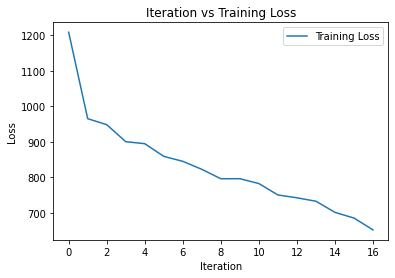

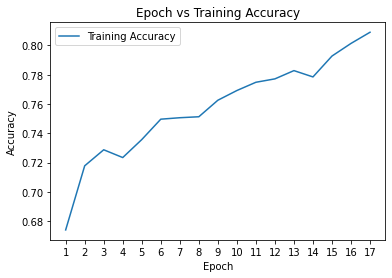

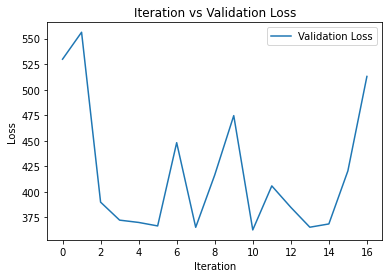

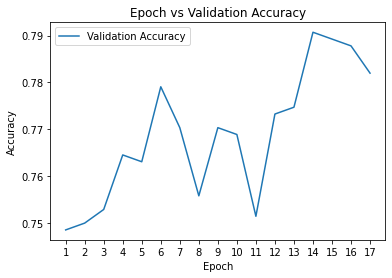

In [ ]:
# Plot Iteration vs train Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs train Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

# Plot Iteration vs Validate Loss
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Validation Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Validation Accuracy
acc_X = np.arange(len(val_accuracies))+1                          
plt.plot(acc_X, val_accuracies,"-", label="Validation Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Validation Accuracy")  
plt.legend()
plt.show()

## 5. Validation

Validate the model.

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/capstone_nobel/model/pytorch_model.bin'))

<All keys matched successfully>

Check the result.

In [ ]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

# Concat test texts and test records
df = pd.concat([val_data.reset_index(), df_record["Model Prediction"]], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["pcr_test_result_inferred"]!=df["Model Prediction"]]

,index,source,audio_path,pcr_test_result_inferred,Model Prediction
0,47,coughvid,virufy-cdf-coughvid/06b58ff7-42e9-49d8-8b56-dd...,1,0
1,62,coughvid,virufy-cdf-coughvid/099f9c59-3206-438d-8fd5-be...,1,0
2,113,coughvid,virufy-cdf-coughvid/12121877-e33a-4cba-b63b-00...,1,0
3,117,coughvid,virufy-cdf-coughvid/126b940c-b6c6-4d3d-adc2-92...,1,0
4,141,coughvid,virufy-cdf-coughvid/178f39e2-a261-4ec6-a8fb-3f...,1,0
...,...,...,...,...,...
362,940,coughvid,virufy-cdf-coughvid/a7e79300-5932-450d-8696-79...,0,1
378,1566,coswara,virufy-cdf-coswara/20200417/fuZ1Iu9k84gcTbZKIW...,0,1
425,1708,coswara,virufy-cdf-coswara/20200413/SY4Ekt5W4VZdeIm5r3...,0,1
476,1642,coswara,virufy-cdf-coswara/20200604/awro2Lz4F9SgVweiUz...,0,1


Display the Confusion Matrix of the result.

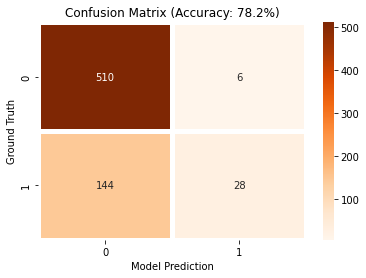

In [ ]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_record["Ground Truth"],df_record["Model Prediction"])
# print(confusion_matrix)
_tp = confusion_matrix[0, 0]
_fn = confusion_matrix[0, 1]
_fp = confusion_matrix[1, 0]
_tn = confusion_matrix[1, 1]
_tpr = _tp / (_tp + _fn)
_fpr = _fp / (_tn + _fp)
print('False positive rate:',_fpr)
print('True positive rate:',_tpr)
auc = roc_auc_score(df_record["Ground Truth"],df_record["Model Prediction"])
print('AUC:',auc)

False positive rate: 0.8372093023255814
True positive rate: 0.9883720930232558
AUC: 0.5755813953488372
